#       InSPIRe Vaginal Resistome Jupyter Notebook (supplementary):
Author : Nassim Boutouchent 

This last Notebook is dedicated to display the PhenoARGTree construction and the conceptual validation of the PRDI: 
to show how the PRDI can improuve our interpretation of diversity in a given resistome, we built two different scenario from synthetical data \
**Case 1**: redundancy (addition of genes with a similar phenotype) and \
**Case 2**: diversification (addition of genes with different phenotypes). Data from 30 synthetic samples per level. 


## Load libraries

In [1]:
import pandas as pd
import numpy as np
import skbio
import matplotlib.pyplot as plt

## Load data 

In [2]:
# phenotypes 
df_pheno = pd.read_csv("../data/supp_materials/phenotypes.txt", sep='\t')
# Mooncrater 
tree_ARG = skbio.TreeNode.read("../data/supp_materials/PhenoARGTree.newick")
tree_rooted_ARG = tree_ARG.root_at(tree_ARG)

In [3]:
df_pheno.head()

,Gene_accession no.,Class,Phenotype,PMID,Mechanism of resistance,Notes,Required_gene
0,ant(2'')-Ia_1_X04555,Aminoglycoside,"Gentamicin, Tobramycin",3024112,Enzymatic modification,Alternative name aadB,NaN
1,ant(2'')-Ia_10_HM367617,Aminoglycoside,"Gentamicin, Tobramycin",21873033,Enzymatic modification,NaN,NaN
2,ant(2'')-Ia_11_HM367620,Aminoglycoside,"Gentamicin, Tobramycin",21873033,Enzymatic modification,NaN,NaN
3,ant(2'')-Ia_12_HQ880250,Aminoglycoside,"Gentamicin, Tobramycin",unpublished,Enzymatic modification,NaN,NaN
4,ant(2'')-Ia_13_DQ176450,Aminoglycoside,"Gentamicin, Tobramycin",16304199,Enzymatic modification,NaN,NaN


In [4]:
# format data 
split_columns = df_pheno['Gene_accession no.'].str.split('_', n=2, expand=True)
df_pheno['Gene'] = split_columns[0]
df_pheno['Variant'] = split_columns[1]
df_pheno['Accession'] = split_columns[2]

# Keep only columns of interest
Cols_to_keep = ['Class','Gene','Phenotype','Accession']
pheno_foramted_df = df_pheno[Cols_to_keep]
print(pheno_foramted_df.shape)
pheno_foramted_df.head()

(3203, 4)


,Class,Gene,Phenotype,Accession
0,Aminoglycoside,ant(2'')-Ia,"Gentamicin, Tobramycin",X04555
1,Aminoglycoside,ant(2'')-Ia,"Gentamicin, Tobramycin",HM367617
2,Aminoglycoside,ant(2'')-Ia,"Gentamicin, Tobramycin",HM367620
3,Aminoglycoside,ant(2'')-Ia,"Gentamicin, Tobramycin",HQ880250
4,Aminoglycoside,ant(2'')-Ia,"Gentamicin, Tobramycin",DQ176450


In [5]:
# select a random set (n=50) of different phenotypes
keep_unique_pheno = pheno_foramted_df.drop_duplicates(subset="Phenotype")
random_pheno_df = keep_unique_pheno.sample(n=50, random_state=42)
random_pheno_df.reset_index(drop=True, inplace=True)

## Phenotypic Resistance Diversity Index (PRDI) conceptual validation 

In [6]:
# generate count table for alpha-div metric calculation 
def add_count(random_df, n_samples=30, lam=100000, dropout=0.1):
# The absolute read count is not critical here, as the analysis focuses on genes
    rng = np.random.default_rng(42)
    samples = [f"Sample_{i+1}" for i in range(n_samples)]
    cols = list(random_df["Accession"])
    sample_scaling = rng.uniform(0.5, 2.0, size=n_samples)
# Inter-sample variability and sparsity are introduced via random scaling and dropout
    counts = {}
    for g in cols:
        base_counts = rng.poisson(lam=lam, size=n_samples)
        scaled = (base_counts * sample_scaling).astype(int)
        mask = rng.random(size=n_samples) < dropout
        scaled[mask] = 0
        counts[g] = scaled
    return pd.DataFrame(counts, index=samples)


def add_genes(random_count_df, prev_table, lam=200, dropout=0.1):
    rng = np.random.default_rng(42)
    tbl = prev_table.copy()
    new_cols = [g for g in random_count_df["Accession"] if g not in tbl.columns]
    sample_scaling = rng.uniform(0.5, 2.0, size=tbl.shape[0])

    for g in new_cols:
        base_counts = rng.poisson(lam=lam, size=tbl.shape[0])
        scaled = (base_counts * sample_scaling).astype(int)
        mask = rng.random(size=tbl.shape[0]) < dropout
        scaled[mask] = 0
        tbl[g] = scaled

    return tbl

def compute_alpha(df, metric, tree=None):
    series = {}
    if metric=="faith_pd": 
        from skbio.diversity.alpha import faith_pd
        taxa_id = df.columns.tolist()
        for idx in df.index: 
            abun = df.loc[idx, taxa_id].astype(float).to_numpy()
            if abun.sum() == 0:
                series[idx] = 0
            else:
                series[idx] = faith_pd(abun, taxa_id, tree, validate=True)
        return pd.Series(series)
    else: 
        for idx in df.index:
            abun = df.loc[idx].dropna()
            if abun.sum() == 0:
                series[idx] = 0
            else: 
                series[idx] = getattr(skbio.diversity.alpha, metric)(abun) 
        return pd.Series(series)
    
    
def plot_alpha(df, x, mean, std, color, title=None, ylim=None, plot=None):
    plot = plot or plt.gca()
    plot.plot(df[x], df[mean], "-o", color=color)
    plot.fill_between(
        df[x],
        df[mean] - df[std],
        df[mean] + df[std],
        color=color,
        alpha=0.2
    )
    plot.set_title(title)
    plot.set_ylim(*ylim)
    plot.grid(True, linestyle="--", alpha=0.4)

    return plot

## Case 1 : Diversity driven by phenotypic redundancy 

In this case we progressively increase gene phenotype redundancy (5/10/20/40/80/100 (%)). 

We hypothesize that such redundancy enrichment will not be captured by conventional metrics (e.g.,specific richness, Shannon), wherease PRDI is expected to have a minimal variations.|

In [7]:
def add_redundancy(prev_df, df_all, target_total):
    random = np.random.default_rng(42)
    out = prev_df.copy()
    used = set(out.Accession)
    phenotypes = out.Phenotype.to_numpy()
    avail = df_all[~df_all.Accession.isin(used)]

    for _ in range((target_total - len(out)) * 20):
        if len(out) >= target_total or avail.empty:
            break
        ph = random.choice(phenotypes)
        pool = avail[avail.Phenotype.eq(ph)]
        if pool.empty:
            continue
        row = pool.iloc[[random.integers(len(pool))]]
        out = pd.concat([out, row], ignore_index=True)
        avail = avail[avail.Accession.ne(row.Accession.iat[0])]
    return out


In [8]:
# Generate 5/10/20/40/80/100% redundancy datasets
df_5   = add_redundancy(random_pheno_df, keep_unique_pheno, 50 + 2)
df_10  = add_redundancy(df_5,            keep_unique_pheno, 50 + 5)
df_20  = add_redundancy(df_10,           keep_unique_pheno, 50 + 10)
df_40  = add_redundancy(df_20,           keep_unique_pheno, 50 + 20)
df_80  = add_redundancy(df_40,           keep_unique_pheno, 50 + 40)
df_100 = add_redundancy(df_80,           keep_unique_pheno, 50 + 50)

# Build count tables
count_base = add_count(random_pheno_df, dropout=0.2)
count_5    = add_genes(df_5,   count_base, dropout=0.2)
count_10   = add_genes(df_10,  count_5,    dropout=0.2)
count_20   = add_genes(df_20,  count_10,   dropout=0.2)
count_40   = add_genes(df_40,  count_20,   dropout=0.2)
count_80   = add_genes(df_80,  count_40,   dropout=0.2)
count_100  = add_genes(df_100, count_80,   dropout=0.2)

# Compute PRDI and Shannon 
tables = {0: count_base, 5: count_5, 10: count_10, 20: count_20, 40: count_40, 80: count_80, 100: count_100}

for t in tables.values():
    t.columns = (t.columns.str.replace(r"^NC_", "NC ", regex=True)
                        .str.replace(r"^NG_", "NG ", regex=True)
                        .str.replace(r"^ENA_", "ENA ", regex=True)
                        .str.replace(r"^NZ_", "NZ ", regex=True))

res = {m: {p: compute_alpha(df, metric=m, tree=tree_rooted_ARG) if m=="faith_pd" else compute_alpha(df, metric=m)
           for p, df in tables.items()}
       for m in ["faith_pd", "shannon"]}

summaries = {m: pd.DataFrame({"Added_ARGs_perc": list(tables),
                             f"{m}_mean": [res[m][p].mean() for p in tables],
                             f"{m}_std":  [res[m][p].std(ddof=1) for p in tables],
                             "n_samples": [len(res[m][p]) for p in tables]
                            }).sort_values("Added_ARGs_perc").reset_index(drop=True)
             for m in res}

print(summaries["faith_pd"])
print(summaries["shannon"])

   Added_ARGs_perc  faith_pd_mean  faith_pd_std  n_samples
0                0      24.433698      1.246625         30
1                5      24.433698      1.246625         30
2               10      24.433698      1.246625         30
3               20      24.433698      1.246625         30
4               40      24.433698      1.246625         30
5               80      24.433698      1.246625         30
6              100      24.433698      1.246625         30
   Added_ARGs_perc  shannon_mean  shannon_std  n_samples
0                0      5.347228     0.078944         30
1                5      5.347228     0.078944         30
2               10      5.347228     0.078944         30
3               20      5.347228     0.078944         30
4               40      5.347228     0.078944         30
5               80      5.347228     0.078944         30
6              100      5.347228     0.078944         30


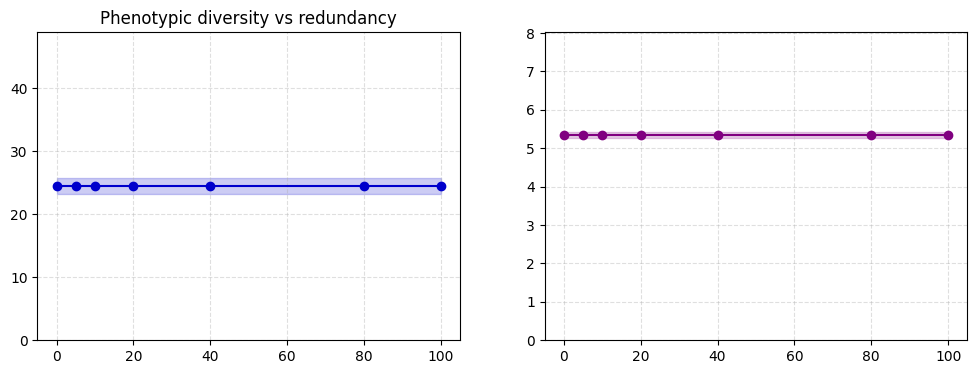

In [9]:
# Plot case 1
summary_prdi_red    = summaries["faith_pd"]
summary_shannon_red = summaries["shannon"]

fig, axes = plt.subplots(1,2, figsize=(12, 4), sharey=False)
ax = plot_alpha(summary_prdi_red,x="Added_ARGs_perc", mean="faith_pd_mean", std="faith_pd_std", color="#0000CC", title="Phenotypic diversity vs redundancy",
    ylim=(0, summary_prdi_red["faith_pd_mean"].max() * 2),plot=axes[0])
ax = plot_alpha(summary_shannon_red,x="Added_ARGs_perc",mean="shannon_mean",std="shannon_std",color="purple", ylim=(0, summary_shannon_red["shannon_mean"].max() * 1.5), plot=axes[1])

## Case 2 : Diversity driven by true phenotypic diversification 

In this second case, we progressively increase true gene–phenotype diversity (i.e. genes associated with distinct phenotypes) (5/10/20/40/80/100 (%)). 

By contrast, we hypothesize that this enrichment will be captured by PRDI, leading to a substantial increase in its value.

In [10]:
def add_diversity(prev_df, df_all, target_total):
    rng = np.random.default_rng(42)
    used_acc = set(prev_df["Accession"])
    used_pheno = set(prev_df["Phenotype"])
    out = prev_df.copy()
    need = target_total - len(prev_df)

    pool = df_all[~df_all["Phenotype"].isin(used_pheno) & ~df_all["Accession"].isin(used_acc)].copy()
    if pool.empty:
        return out
    extras = pool.groupby("Phenotype").sample(n=1, random_state=int(rng.integers(0, 1_000_000_000)))
    if len(extras) > need:
        extras = extras.sample(n=need, random_state=int(rng.integers(0, 1_000_000_000)))
    out = pd.concat([out, extras], ignore_index=True)
    
    return out

In [11]:
# Generate 5/10/20/40/80/100% redundancy datasets
df_5   = add_diversity(random_pheno_df, keep_unique_pheno, 50 + 2)
df_10  = add_diversity(df_5,            keep_unique_pheno, 50 + 5)
df_20  = add_diversity(df_10,           keep_unique_pheno, 50 + 10)
df_40  = add_diversity(df_20,           keep_unique_pheno, 50 + 20)
df_80  = add_diversity(df_40,           keep_unique_pheno, 50 + 40)
df_100 = add_diversity(df_80,           keep_unique_pheno, 50 + 50)

# Build count tables
count_base = add_count(random_pheno_df, dropout=0.2)
count_5    = add_genes(df_5,   count_base, dropout=0.2)
count_10   = add_genes(df_10,  count_5,    dropout=0.2)
count_20   = add_genes(df_20,  count_10,   dropout=0.2)
count_40   = add_genes(df_40,  count_20,   dropout=0.2)
count_80   = add_genes(df_80,  count_40,   dropout=0.2)
count_100  = add_genes(df_100, count_80,   dropout=0.2)

# Compute PRDI and Shannon 
tables = {0: count_base, 5: count_5, 10: count_10, 20: count_20, 40: count_40, 80: count_80, 100: count_100}

for t in tables.values():
    t.columns = (t.columns.str.replace(r"^NC_", "NC ", regex=True)
                        .str.replace(r"^NG_", "NG ", regex=True)
                        .str.replace(r"^ENA_", "ENA ", regex=True)
                        .str.replace(r"^NZ_", "NZ ", regex=True))

res = {m: {p: compute_alpha(df, metric=m, tree=tree_rooted_ARG) if m=="faith_pd" else compute_alpha(df, metric=m)
           for p, df in tables.items()}
       for m in ["faith_pd", "shannon"]}

summaries = {m: pd.DataFrame({"Added_ARGs_perc": list(tables),
                             f"{m}_mean": [res[m][p].mean() for p in tables],
                             f"{m}_std":  [res[m][p].std(ddof=1) for p in tables],
                             "n_samples": [len(res[m][p]) for p in tables]
                            }).sort_values("Added_ARGs_perc").reset_index(drop=True)
             for m in res}

print(summaries["faith_pd"])
print(summaries["shannon"])

   Added_ARGs_perc  faith_pd_mean  faith_pd_std  n_samples
0                0      24.433698      1.246625         30
1                5      25.054212      1.258855         30
2               10      26.121552      1.450172         30
3               20      27.400246      1.602115         30
4               40      30.531826      1.718537         30
5               80      39.206362      2.686190         30
6              100      43.357823      3.010722         30
   Added_ARGs_perc  shannon_mean  shannon_std  n_samples
0                0      5.347228     0.078944         30
1                5      5.347979     0.078918         30
2               10      5.349159     0.078886         30
3               20      5.351184     0.078836         30
4               40      5.355255     0.078659         30
5               80      5.363354     0.078327         30
6              100      5.367415     0.078163         30


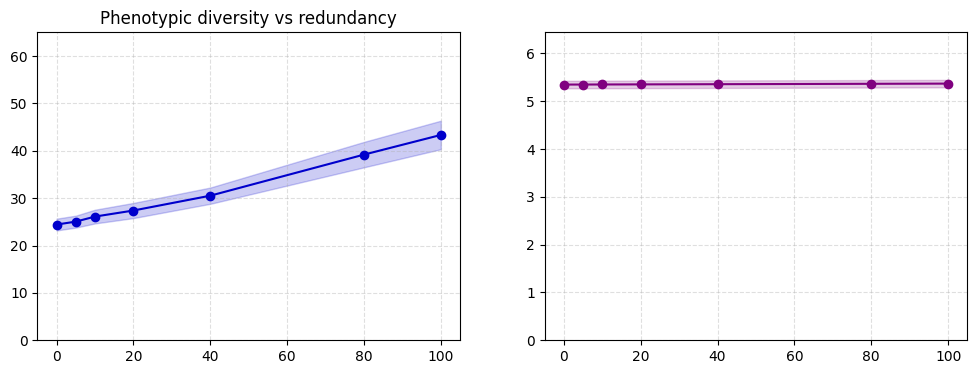

In [12]:
# Plot case 2
summary_prdi_div    = summaries["faith_pd"]
summary_shannon_div = summaries["shannon"]

fig, axes = plt.subplots(1,2, figsize=(12, 4), sharey=False)
ax = plot_alpha(summary_prdi_div,x="Added_ARGs_perc", mean="faith_pd_mean", std="faith_pd_std", color="#0000CC", title="Phenotypic diversity vs redundancy",
    ylim=(0, summary_prdi_div["faith_pd_mean"].max() * 1.5),plot=axes[0])
ax = plot_alpha(summary_shannon_div,x="Added_ARGs_perc",mean="shannon_mean",std="shannon_std",color="purple", ylim=(0, summary_shannon_div["shannon_mean"].max() * 1.2), plot=axes[1])

In [13]:
import statsmodels.api as sm
from scipy.stats import spearmanr

# format 
df = (summary_prdi_div.rename(columns={"Added_ARGs_perc": "level",
                                     "faith_pd_mean": "PRDI_div"})
                                     .merge(summary_prdi_red.rename(columns={"Added_ARGs_perc": "level",
                                            "faith_pd_mean": "PRDI_red"}),on="level"))
# Delta PRDI
df["PRDI_delta"] = df["PRDI_div"] - df["PRDI_red"]

# OLS with robust SE (HC3)
fit = sm.OLS(df["PRDI_delta"], sm.add_constant(df["level"])).fit(cov_type="HC3")
b = fit.params["level"]
se = fit.bse["level"]
p = fit.pvalues["level"]
ci = fit.conf_int().loc["level"]

# Spearman correlation
rho, p_s = spearmanr(df["level"], df["PRDI_delta"])

print(f"ΔPRDI ~ % ARG added (OLS HC3): {b:.2f}/% "
      f"(95% CI {ci[0]:.2f}–{ci[1]:.2f}), p={p:.2e}\n"    
      f"⇢ +10% ARGs: {10*b:.2f} PRDI\n"
      f"Spearman Δ: rho={rho:.2f}, p={p_s:.1e}")

ΔPRDI ~ % ARG added (OLS HC3): 0.19/% (95% CI 0.18–0.20), p=2.08e-150
⇢ +10% ARGs: 1.90 PRDI
Spearman Δ: rho=1.00, p=0.0e+00
